In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings

In [48]:
pd.set_option('mode.chained_assignment', None)  # SettingWithCopyWarning 경고 무시
warnings.simplefilter(action='ignore', category=[FutureWarning]) # FutureWarning 제거

In [4]:
"""
데이터 로드
"""
train = pd.read_csv("./dataset/train.csv")
test = pd.read_csv("./dataset/test.csv")
submit = pd.read_csv("./dataset/raw/sample_submission.csv")
test_label = pd.read_csv("./dataset/raw/test_label.csv")

with open("./dataset/candidates_pre.pkl", 'rb') as f:
            cand_pre = pickle.load(f)

with open("./dataset/candidates_test_pre.pkl", 'rb') as f:
            cand_pre_test = pickle.load(f)

In [5]:
print("*train NaN: \n", train[train.columns].isnull().sum())
print()
print("*test NaN: \n", test[test.columns].isnull().sum())

*train NaN: 
 precipitation    678
temp_mean          0
temp_highest       0
temp_lowest        0
PM10               0
PM2.5              0
humidity           0
sunshine_sum       0
sunshine_rate      0
wind_mean          0
wind_max           0
rental             0
year               0
month              0
day                0
dtype: int64

*test NaN: 
 precipitation    205
temp_mean          0
temp_highest       0
temp_lowest        0
PM10               0
PM2.5              0
humidity           0
sunshine_sum       0
sunshine_rate      0
wind_mean          0
wind_max           0
year               0
month              0
day                0
dtype: int64


In [6]:
# 벤치마크 함수
def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

In [7]:
"""
Naive 데이터
"""
columns = train.columns.difference(['rental', 'dayofweek'])
# ['precipitation', 'temp_mean', 'temp_highest', 'temp_lowest', 'PM10', 'PM2.5', 
# 'humidity', 'sunshine_sum', 'sunshine_rate', 'wind_mean',
# 'wind_max', 'year', 'month', 'day', 'holiday']

# 강수량 결측
isnull = train['precipitation'].isnull()
isnull_test = test['precipitation'].isnull()

# Raw X, Y set: 학습 데이터, 라벨 분리 (강수량 결측치)
X = np.array(train[columns].values.tolist())
Y = np.array(train['rental'].values.tolist())
X_test = np.array(test[columns].values.tolist())
Y_test = np.array(test_label['rental'].values.tolist())

isnan = np.isnan(X)
isnan_test = np.isnan(X_test)

<AxesSubplot:>

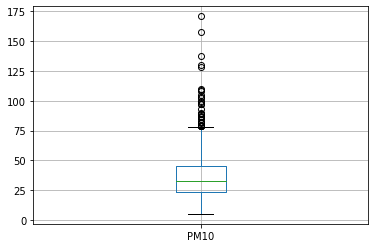

In [8]:
# outliers
fig, ax = plt.subplots()
train.boxplot(column='PM10')

# Random Forest
## Naive (all features)

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [336]:
# 강수량
for i in ['poly', 'exp', 'mean']:
    X[isnan] = cand_pre[i]   # 결측치
    X_test[isnan_test] = cand_pre_test[i]
    
    reg = RandomForestRegressor()
    reg.fit(X, Y)
    pred = reg.predict(X)
    pred_test = reg.predict(X_test)
    
    score = NMAE(Y, pred)
    score_test = NMAE(Y_test, pred_test)
    print("====[", i, "]====")
    print("Train score: ", score)
    print("Test score: ", score_test)
    print()

====[ poly ]====
Train score:  0.07582669695871144
Test score:  0.3514099406051553

====[ exp ]====
Train score:  0.07111660352835492
Test score:  0.3381432471037166

====[ mean ]====
Train score:  0.07455183277526252
Test score:  0.3450717822748698



In [ ]:
columns = train.columns.difference[['']]


# GBR
## Naive (all features)

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

In [337]:
# 강수량
for i in ['poly', 'exp', 'mean']:
    X[isnan] = cand_pre[i]   # 결측치
    X_test[isnan_test] = cand_pre_test[i]
    
    reg = GradientBoostingRegressor()
    reg.fit(X, Y)
    pred = reg.predict(X)
    pred_test = reg.predict(X_test)
    
    score = NMAE(Y, pred)
    score_test = NMAE(Y_test, pred_test)
    print("====[", i, "]====")
    print("Train score: ", score)
    print("Test score: ", score_test)
    print()

====[ poly ]====
Train score:  0.12001299769898938
Test score:  0.3370589386390601

====[ exp ]====
Train score:  0.1170689723486645
Test score:  0.31138220813759016

====[ mean ]====
Train score:  0.127141213734897
Test score:  0.30669484686919707



AttributeError: 'XGBRegressor' object has no attribute 'feature_importance'

# XGBoost
## Naive (all features)

In [234]:
from xgboost import XGBRegressor

In [338]:
# 강수량
for i in ['poly', 'exp', 'mean']:
    X[isnan] = cand_pre[i]   # 결측치
    X_test[isnan_test] = cand_pre_test[i]
    
    reg = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
    reg.fit(X, Y)
    pred = reg.predict(X)
    pred_test = reg.predict(X_test)
    
    score = NMAE(Y, pred)
    score_test = NMAE(Y_test, pred_test)
    print("====[", i, "]====")
    print("Train score: ", score)
    print("Test score: ", score_test)
    print()

====[ poly ]====
Train score:  0.023752990197584166
Test score:  0.338089506080651

====[ exp ]====
Train score:  0.022299652534742205
Test score:  0.32785422702259087

====[ mean ]====
Train score:  0.024813216831270253
Test score:  0.34241937715018284



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

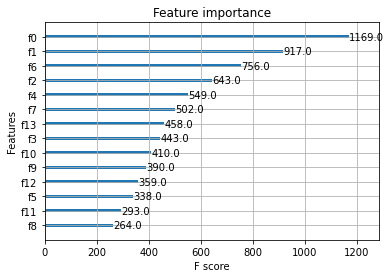

In [49]:
xgboost.plot_importance(reg)

## Feature importance 상위 6개

In [69]:
columns = [train.columns[0], train.columns[1], train.columns[6], train.columns[2], train.columns[4], train.columns[7]]
x = np.array(train[columns].values.tolist())
x_test = np.array(test[columns].values.tolist())

nan = np.isnan(x)
nan_test = np.isnan(x_test)

In [70]:
# 강수량
for i in ['poly', 'exp', 'mean']:
    x[nan] = cand_pre[i]   # 결측치
    x_test[nan_test] = cand_pre_test[i]
    
    reg = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
    reg.fit(x, Y)
    pred = reg.predict(x)
    pred_test = reg.predict(x_test)
    
    score = NMAE(Y, pred)
    score_test = NMAE(Y_test, pred_test)
    print("====[", i, "]====")
    print("Train score: ", score)
    print("Test score: ", score_test)
    print()
    
# 결과가 더 안좋음.

====[ poly ]====
Train score:  0.13864509130313543
Test score:  0.45996365223717645

====[ exp ]====
Train score:  0.09502172938404253
Test score:  0.39462231737492987

====[ mean ]====
Train score:  0.10098135748501658
Test score:  0.4354861416576763



# Feature Engineering
- train, test에 변화 있으면 위로 올라가서 X,X_train 업데이트 해주기
## holiday

In [9]:
# Train
from datetime import datetime
date = train['year'].map(str)+'-'+train['month'].map(str)+'-'+train['day'].map(str)
df = pd.DataFrame(columns=['holiday', 'dayofweek'])

dateDict = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}

for d in date:
    datetime_date = datetime.strptime(d, '%Y-%m-%d')
    week = datetime_date.weekday()
    if (week == 5) | (week == 6):
        holi = 1
    else:
        holi = 0
    dow = dateDict[week]
    
    df = df.append({'holiday': holi, 'dayofweek': dow}, ignore_index=True)
    

In [10]:
train['holiday'] = df['holiday']
train['dayofweek'] = df['dayofweek']

In [11]:
# Test
from datetime import datetime
date = test['year'].map(str)+'-'+test['month'].map(str)+'-'+test['day'].map(str)
df = pd.DataFrame(columns=['holiday', 'dayofweek'])

dateDict = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}

for d in date:
    datetime_date = datetime.strptime(d, '%Y-%m-%d')
    week = datetime_date.weekday()
    if (week == 5) | (week == 6):
        holi = 1
    else:
        holi = 0
    dow = dateDict[week]
    
    df = df.append({'holiday': holi, 'dayofweek': dow}, ignore_index=True)
    

In [12]:
test['holiday'] = df['holiday'].map(int)
test['dayofweek'] = df['dayofweek']

## trend
- 2018\~2019, 2019\~2020년도 각 월별 증가량 추이
- 추세선을 찾음 (아래는 statsmodel DeterministicProcess 설명)
- Directly supports constants, time trends, and either seasonal dummies or fourier terms for a single cycle. Additional deterministic terms beyond the set that can be directly initialized through the constructor can be added.

In [61]:
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

In [367]:
# XGBoost
columns = train.columns.difference(['rental', 'dayofweek', 'sunshine_rate', 'PM10', 'PM2.5'])
x = train[columns]
y = train['rental']

x_test = test[columns]
y_test = test_label['rental']

order = 1
dp = DeterministicProcess(index=x.index, constant=True, order=order, drop=True)
output = dp.in_sample()

isnull = x['precipitation'].isnull()
isnull_test = x_test['precipitation'].isnull()

train_trend = []
test_trend = []
train_pred = []
test_pred = []

for i in ['poly', 'exp', 'mean']:
    x['precipitation'].loc[isnull] = cand_pre[i]   # 결측치
    x_test['precipitation'].loc[isnull_test] = cand_pre_test[i]

    test_const = [1 for i in range(x_test.shape[0])]
    test_trend = np.arange(output['trend'].max(), output['trend'].max()+x_test.shape[0])
    
    test_trend_squared = [i**2 for i in test_trend]
    test_trend_cubed = [i**3 for i in test_trend]
    test_trend_4 = [i**4 for i in test_trend]
    test_trend_5 = [i**5 for i in test_trend]
    test_trend_6 = [i**6 for i in test_trend]
    
    output_test = pd.DataFrame([test_const, test_trend]).T
    output_test.columns = ['const', 'trend']
    output_test.index = x_test.index

    lm = LinearRegression()
    lm.fit(output, y)
    
    trend_train = lm.predict(output)
    trend_test = lm.predict(output_test)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

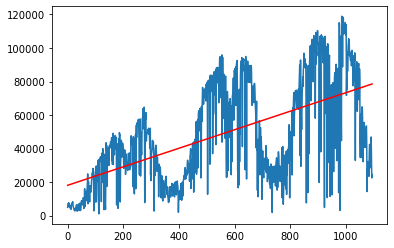

In [368]:
    plt.plot(y)
    plt.plot(x.index, trend_train, 'r-')
    y_delta = y / trend_train
    
    
#     train_y_delta = np.array(y) - trend_train
#     test_y_delta = np.array(y_test) - trend_test

    xgb= XGBRegressor()
    xgb.fit(np.array(x), y_delta)

    xgb_train = xgb.predict(np.array(x))
    xgb_test = xgb.predict(x_test)
    
    train_trend.append(trend_train)
    test_trend.append(trend_test)
    train_pred.append(xgb_train)
    test_pred.append(xgb_test)
    
    print("====[", i, "]====")
    print("train NMAE: ", NMAE(np.array(y), xgb_train * trend_train))
    print("train NMAE: ", NMAE(np.array(y_test), xgb_test * trend_test))

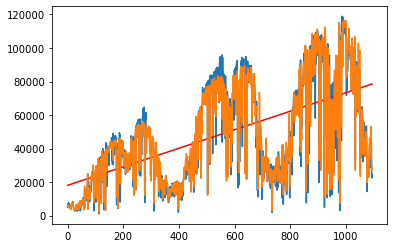

In [296]:
plt.plot(y)
plt.plot(x.index, trend_train, 'r-')
plt.plot(xgb_train * trend_train)

In [258]:
submit['rental'] = xgb_test * trend_test

In [260]:
NMAE(np.array(y_test), xgb_test * trend_test)

0.20026045356239405

In [261]:
submit.to_csv("./dataset/submit_trend_mean.csv", sep=',', na_rep="NaN", index=False)

In [224]:
trend_train

array([10842.40890799, 10937.46927968, 11032.45675145, ...,
       71222.8805915 , 71238.33426439, 71253.71503736])

### GBR

In [62]:
from sklearn.model_selection import GridSearchCV

In [63]:
train.columns

Index(['precipitation', 'temp_mean', 'temp_highest', 'temp_lowest', 'PM10',
       'PM2.5', 'humidity', 'sunshine_sum', 'sunshine_rate', 'wind_mean',
       'wind_max', 'rental', 'year', 'month', 'day', 'holiday', 'dayofweek'],
      dtype='object')

In [154]:
best = 0

====[ poly ]====
train NMAE:  0.14277829360185518
test NMAE:  0.2057000444794428
====[ exp ]====
train NMAE:  0.13055439782708472
test NMAE:  0.1765640353921126
====[ mean ]====
train NMAE:  0.14094724384890553
test NMAE:  0.20181366537241796
====[ poly ]====
train NMAE:  0.14277829360185518
test NMAE:  0.2056014837569742
====[ exp ]====
train NMAE:  0.13055439782708472
test NMAE:  0.17671270027658809
====[ mean ]====
train NMAE:  0.14094724384890556
test NMAE:  0.20080701546441193
====[ poly ]====
train NMAE:  0.14277829360185518
test NMAE:  0.20575912104636038
====[ exp ]====
train NMAE:  0.13055439782708472
test NMAE:  0.17526023773471175
====[ mean ]====
train NMAE:  0.14094724384890556
test NMAE:  0.1990562203323306
====[ poly ]====
train NMAE:  0.14277829360185518
test NMAE:  0.20583486389711192
====[ exp ]====
train NMAE:  0.13055439782708472
test NMAE:  0.17656734986396924
====[ mean ]====
train NMAE:  0.14094724384890553
test NMAE:  0.2020990096760276
====[ poly ]====
train NM

====[ poly ]====
train NMAE:  0.1427782936018552
test NMAE:  0.20572697944293486
====[ exp ]====
train NMAE:  0.13055439782708472
test NMAE:  0.1753200417036067
====[ mean ]====
train NMAE:  0.14094724384890558
test NMAE:  0.20340118831970116
====[ poly ]====
train NMAE:  0.14277829360185518
test NMAE:  0.2056336253603997
====[ exp ]====
train NMAE:  0.1305543978270847
test NMAE:  0.1766779579273236
====[ mean ]====
train NMAE:  0.14094724384890553
test NMAE:  0.2005692172579055
====[ poly ]====
train NMAE:  0.1427782936018552
test NMAE:  0.20572697944293492
====[ exp ]====
train NMAE:  0.13055439782708472
test NMAE:  0.17544992644758764
====[ mean ]====
train NMAE:  0.14094724384890556
test NMAE:  0.20213104499066253
====[ poly ]====
train NMAE:  0.1427782936018552
test NMAE:  0.20572896269407046
====[ exp ]====
train NMAE:  0.13055439782708472
test NMAE:  0.17543554136224393
====[ mean ]====
train NMAE:  0.14094724384890558
test NMAE:  0.20043256055298286
====[ poly ]====
train NMAE:

====[ poly ]====
train NMAE:  0.14277829360185518
test NMAE:  0.20563362536039978
====[ exp ]====
train NMAE:  0.13055439782708472
test NMAE:  0.17546024460611273
====[ mean ]====
train NMAE:  0.14094724384890553
test NMAE:  0.20217881409966842
====[ poly ]====
train NMAE:  0.1427782936018552
test NMAE:  0.20572896269407054
====[ exp ]====
train NMAE:  0.13055439782708472
test NMAE:  0.17517469129098792
====[ mean ]====
train NMAE:  0.14094724384890553
test NMAE:  0.2006925807710548
====[ poly ]====
train NMAE:  0.14277829360185518
test NMAE:  0.20570004447944287
====[ exp ]====
train NMAE:  0.13055439782708472
test NMAE:  0.17657541679744482
====[ mean ]====
train NMAE:  0.14094724384890553
test NMAE:  0.20055776732968683
====[ poly ]====
train NMAE:  0.14277829360185518
test NMAE:  0.20560346700810977
====[ exp ]====
train NMAE:  0.13055439782708472
test NMAE:  0.1753232161642519
====[ mean ]====
train NMAE:  0.14094724384890556
test NMAE:  0.20201905359125757
====[ poly ]====
train 

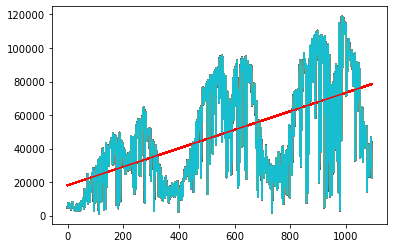

In [163]:
# GBR
# columns = train.columns.difference(['rental', 'dayofweek'])
# columns = ['precipitation', 'temp_highest', 'PM2.5', 'sunshine_sum', 'holiday', 'wind_max', 'month']
# columns = ['precipitation', 'temp_highest', 'PM2.5', 'sunshine_sum', 'holiday', 'wind_max', 'month']
columns = ['precipitation', 'temp_highest', 'PM2.5', 'sunshine_sum', 'holiday', 'wind_mean', 'month']
x = train[columns]
y = train['rental']

x_test = test[columns]
y_test = test_label['rental']

order = 1
dp = DeterministicProcess(index=x.index, constant=True, order=order, drop=True)
output = dp.in_sample()

train_trends = []
test_trends = []
train_pred = []
test_pred = []

isnull = x['precipitation'].isnull()
isnull_test = x_test['precipitation'].isnull()

save = 0
best = 0
best_score = 10000

for _ in range(100):
    for i in ['poly', 'exp', 'mean']:
        x['precipitation'].loc[isnull] = cand_pre[i]   # 결측치
        x_test['precipitation'].loc[isnull_test] = cand_pre_test[i]

        test_const = [1 for i in range(x_test.shape[0])]
        test_trend = np.arange(output['trend'].max(), output['trend'].max()+x_test.shape[0])

        test_trend_squared = [k**2 for k in test_trend]
        test_trend_cubed = [k**3 for k in test_trend]
        test_trend_4 = [k**4 for k in test_trend]
        test_trend_5 = [k**5 for k in test_trend]
        test_trend_6 = [k**6 for k in test_trend]

        output_test = pd.DataFrame([test_const, test_trend]).T
        output_test.columns = ['const', 'trend']
        output_test.index = x_test.index


        lm = LinearRegression()
        lm.fit(output, y)

        trend_train = lm.predict(output)
        trend_test = lm.predict(output_test)

        train_trends.append(trend_train)
        test_trends.append(trend_test)

        plt.plot(y)
        plt.plot(x.index, trend_train, 'r-')
        y_delta = y / trend_train


        gbr= GradientBoostingRegressor()
        gbr.fit(np.array(x), y_delta)

    #     print(gbr.get_params())
    #     gbr_params = {'max_depth' : [3, 4, 6, 8,10] , 'n_estimators': [12,24,32,100,300, 400,600], 'learning_rate':[0.1, 0.2, 0.5, 1]}
    #     grid_search_gbr = GridSearchCV(estimator = gbr, param_grid = gbr_params, cv = 10)

    #     grid_search_gbr.fit(np.array(x), y_delta)
    #     best_gbr = grid_search_gbr.best_estimator_

    #     best.append(best_gbr)

    #     features = gbr.feature_importances_
    #     idx = np.argsort(features)
    #     print(columns[idx])
        gbr_train = gbr.predict(np.array(x))
        gbr_test = gbr.predict(np.array(x_test))

        train_pred.append(gbr_train)
        test_pred.append(gbr_test)


        print("====[", i, "]====")
        score = NMAE(np.array(y_test), gbr_test * trend_test)
        print("train NMAE: ", NMAE(np.array(y), gbr_train * trend_train))
        print("test NMAE: ", score)
#         print(best)
        if score < best_score:
            best = gbr_test * trend_test
            best_score = score

In [164]:
best_score

0.17516437313246278

In [147]:
submit_half = submit['rental'].sample(frac=0.5, replace=False)
y_half = test_label['rental'].iloc[submit_half.index]
NMAE(y_half, submit_half)

0.19474508679784117

In [143]:
submit['rental'] = test_trends[1]*test_pred[1]
NMAE(np.array(y_test), test_trends[1]*test_pred[1])

0.1765784204774563

In [148]:
submit.to_csv("./dataset/submit_trend_exp_gbr_0.176.csv", sep=',', na_rep="NaN", index=False)

In [ ]:
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor


xgb = XGBRegressor()
gbr = GradientBoostingRegressor()


xgb_params = {'max_depth' : [4,5,6], 'n_estimators' : [5,10,30,50,100,500,1000], 'learning_rate' : [0.01, 0.1]}
gbr_params = {'max_depth' : [3,4,5,6] , 'n_estimators': [12,24,32,100,400], 'learning_rate':[0.01, 0.1], 'gamma': [0.5, 1, 2], 'random_state':[99]}

grid_search_xgb = model_selection.GridSearchCV(estimator = xgb, param_grid = xgb_params, scoring = 'recall', cv = 5)
grid_search_gbr = model_selection.GridSearchCV(estimator = gbr, param_grid = xgb_params, scoring = 'recall', cv = 5)

x = X.copy()

grid_search_xgb.fit(x, y_delta)


best_xgb = grid_search_xgb.best_estimator_
best_xgb

In [268]:
submit['rental'] = save[1]
NMAE(np.array(y_test), save[1])
submit.to_csv("./dataset/submit_trend_mean_gbr.csv", sep=',', na_rep="NaN", index=False)

In [125]:
submit_half = submit['rental'].sample(frac=0.5, replace=False)
y_half = test_label['rental'].iloc[submit_half.index]
NMAE(y_half, submit_half)

0.1724428859774833

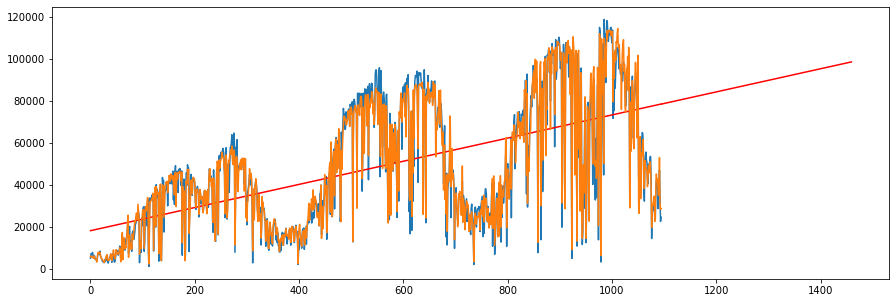

In [324]:
fig = plt.figure(figsize=(15, 5))
plt.plot(y)
plt.plot(x.index, train_trends[1], 'r-')
plt.plot(train_pred[1] * train_trends[1])
plt.plot(x_test.index+1095, test_trends[1], 'r-')

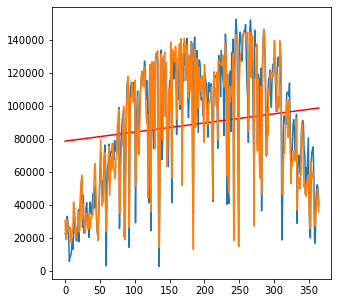

In [322]:
fig = plt.figure(figsize=(5, 5))
plt.plot(y_test)
plt.plot(x_test.index, test_trends[1], 'r-')
plt.plot(test_pred[1] * test_trends[1])

In [320]:
train_trends[1]

array([18106.53232343, 18161.75289576, 18216.97346809, ...,
       78407.39730816, 78462.61788049, 78517.83845282])

### 추세 직접 계산

In [13]:
"""
추세 직접 계산
"""

d = []
    
for j in range(0, len(train)-1):
    today = train.iloc[j]['rental']
    next_ = train.iloc[j+1]['rental']
    d.append((next_ - today) / today)

In [41]:
lm = LinearRegression()
lm.fit(x, d)

LinearRegression()

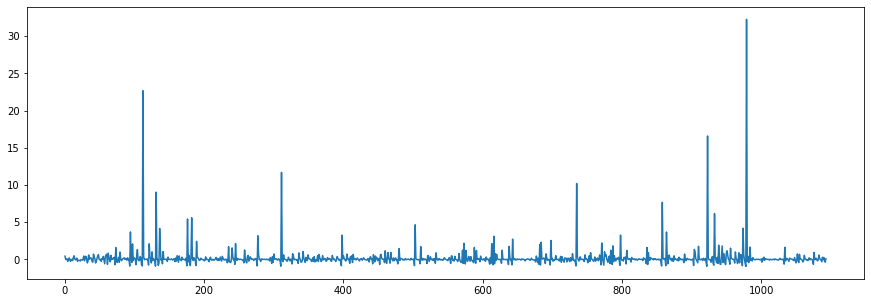

In [59]:
plt.figure(figsize=(15, 5))
plt.plot(d, linestyle='-')

In [ ]:
d = []
   
for j in range(0, len(train)-1):
    today = train.iloc[j]['rental']
    next_ = train.iloc[j+1]['rental']
    d.append((next_ - today) / today)

1094
678 205
====[ poly ]====
train NMAE:  0.1620792257588752
test NMAE:  0.43616686381120146
====[ exp ]====
train NMAE:  0.16570534548543106
test NMAE:  0.42907972717785575
====[ mean ]====
train NMAE:  0.15915163201586915
test NMAE:  0.4143158709247493


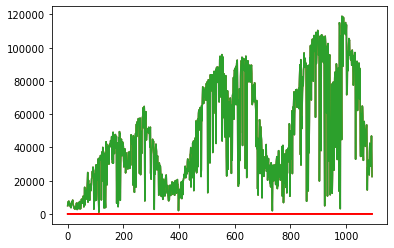

In [52]:
# GBR
columns = train.columns.difference(['rental', 'dayofweek', 'sunshine_rate', 'PM10', 'PM2.5'])
x = train[columns][:-1]
y = train['rental'][:-1]

print(len(x))
x_test = test[columns]
y_test = test_label['rental']

order = 3
dp = DeterministicProcess(index=x.index, constant=True, order=order, drop=True)
output = dp.in_sample()

train_trends = []
test_trends = []
train_pred = []
test_pred = []

isnull = x['precipitation'].isnull()
isnull_test = x_test['precipitation'].isnull()
print(len(isnull[isnull]), len(isnull_test[isnull_test]))

save = []
best = 0

for i in ['poly', 'exp', 'mean']:
    x['precipitation'].loc[isnull] = cand_pre[i]   # 결측치
    x_test['precipitation'].loc[isnull_test] = cand_pre_test[i]

    test_const = [1 for k in range(x_test.shape[0])]
    test_trend = np.arange(output['trend'].max(), output['trend'].max()+x_test.shape[0])
    
    test_trend_squared = [k**2 for k in test_trend]
    test_trend_cubed = [k**3 for k in test_trend]
    test_trend_4 = [k**4 for k in test_trend]
    test_trend_5 = [k**5 for k in test_trend]
    test_trend_6 = [k**6 for k in test_trend]
    
    output_test = pd.DataFrame([test_const, test_trend, test_trend_squared, test_trend_cubed]).T
    output_test.columns = ['const', 'trend', 'trend_squared', 'trend_cubed']
    output_test.index = x_test.index


    lm = LinearRegression()
    lm.fit(output, d)
    
    trend_train = lm.predict(output)
    trend_test = lm.predict(output_test)
    
    train_trends.append(trend_train)
    test_trends.append(trend_test)
    
    plt.plot(y)
    plt.plot(x.index, trend_train, 'r-')
    y_delta = y / trend_train
    
    train_y_delta = np.array(y) - trend_train
    test_y_delta = np.array(y_test) - trend_test

    gbr= GradientBoostingRegressor()
    gbr.fit(np.array(x), y_delta)
    
#     print(gbr.get_params())
#     gbr_params = {'max_depth' : [3, 4, 6, 8,10] , 'n_estimators': [12,24,32,100,400,600], 'learning_rate':[0.1, 0.2, 0.5, 1]}
#     grid_search_gbr = GridSearchCV(estimator = gbr, param_grid = gbr_params, cv = 10)
    
#     grid_search_gbr.fit(np.array(x), y_delta)
#     best_gbr = grid_search_gbr.best_estimator_
    
#     best.append(best_gbr)
    
    gbr_train = gbr.predict(np.array(x))
    gbr_test = gbr.predict(np.array(x_test))
    
    train_pred.append(gbr_train)
    test_pred.append(gbr_test)
    
    print("====[", i, "]====")
    print("train NMAE: ", NMAE(np.array(y), gbr_train * trend_train))
    print("test NMAE: ", NMAE(np.array(y_test), gbr_test * trend_test))

In [50]:
output

,const,trend,trend_squared
0,1.0,1.0,1.0
1,1.0,2.0,4.0
2,1.0,3.0,9.0
3,1.0,4.0,16.0
4,1.0,5.0,25.0
...,...,...,...
1089,1.0,1090.0,1188100.0
1090,1.0,1091.0,1190281.0
1091,1.0,1092.0,1192464.0
1092,1.0,1093.0,1194649.0


In [196]:
# 월별 변화량
d18 = []
d19 = []
d20 = []

for i in range(1, 13):
    d1819[i] = (s2019[i] - s2018[i])/s2018[i]
    d1920[i] = (s2020[i] - s2019[i])/s2019[i]
    d1820[i] = (s2020[i] - s2018[i])/s2018[i]

IndexError: list assignment index out of range

In [24]:
len(x['precipitation'].loc[isnull])

678

In [197]:
train_2018

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day,holiday,dayofweek
0,NaN,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950,2018,1,1,0,mon
1,NaN,-1.8,1.8,-4.3,36.0,22.0,42.0,7.9,82.3,1.8,4.9,7136,2018,1,2,0,tue
2,NaN,-4.7,-0.4,-7.1,31.0,19.0,42.3,8.6,88.7,2.2,3.5,7156,2018,1,3,0,wed
3,NaN,-4.7,-0.7,-8.7,39.0,24.0,43.0,6.2,63.9,1.4,3.5,7102,2018,1,4,0,thu
4,NaN,-3.0,1.6,-5.6,51.0,35.0,48.4,8.2,84.5,1.7,3.6,7705,2018,1,5,0,fri
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,NaN,-10.1,-6.5,-12.5,26.0,9.0,28.3,8.7,90.6,3.5,5.8,11325,2018,12,27,0,thu
361,NaN,-10.5,-6.6,-14.4,33.0,13.0,33.0,8.7,90.6,2.5,4.4,10445,2018,12,28,0,fri
362,NaN,-7.6,-3.0,-10.5,36.0,9.0,29.0,8.7,90.6,2.9,5.5,8083,2018,12,29,1,sat
363,NaN,-6.8,-0.9,-11.3,30.0,15.0,35.9,8.7,90.6,1.2,3.1,7864,2018,12,30,1,sun


## New Features

In [ ]:
# train['temp_diff'] = train['temp_highest'] - train['temp_lowest']
# train['sweat'] = train['temp_highest'] * train['humidity']
# train['cold'] = train['temp_lowest'] * train['wind_mean']

# # test
# test['temp_diff'] = test['temp_highest'] - test['temp_lowest']
# test['sweat'] = test['temp_highest'] * test['humidity']
# test['cold'] = test['temp_lowest'] * test['wind_mean']